In [3]:
!pip install pyarrow scikit-learn pandas keras matplotlib seaborn

In [4]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
folder_path = './content/'
all_files = glob.glob(os.path.join(folder_path, '*.parquet'))
print("Files found:", all_files)

Files found: ['./content\\Benign-Monday-no-metadata.parquet', './content\\Botnet-Friday-no-metadata.parquet', './content\\Bruteforce-Tuesday-no-metadata.parquet', './content\\DDoS-Friday-no-metadata.parquet', './content\\DoS-Wednesday-no-metadata.parquet', './content\\Infiltration-Thursday-no-metadata.parquet', './content\\Portscan-Friday-no-metadata.parquet', './content\\WebAttacks-Thursday-no-metadata.parquet']


In [6]:
df_list = [pd.read_parquet(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)
print("Total samples:", df.shape)

Total samples: (2313810, 78)


In [7]:
label_col = df['Label']  # save it first

df = df.select_dtypes(include=[np.number])  # drop non-numerics
df['Label'] = label_col  # add Label back


In [8]:
# Check the unique values in the 'Label' column
print("Unique attack labels in the 'Label' column:")
print(df['Label'].value_counts())

# Optionally, list all unique attack types (if 'Label' is text-based)
print("\nUnique attack types in the 'Label' column (text-based):")
print(df['Label'].unique())

Unique attack labels in the 'Label' column:
Label
Benign                        1977318
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Unique attack types in the 'Label' column (text-based):
['Benign' 'Bot' 'FTP-Patator' 'SSH-Patator' 'DDoS' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Infiltration'
 'PortScan' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']


In [9]:
# Assuming 'Label' column has different attack types and 'BENIGN' is normal traffic
attack_types = ['Benign', 'DDoS', 'Infiltration', 'Web Attack � Brute Force',
 'Web Attack � XSS', 'Web Attack � Sql Injection', 'FTP-Patator',
 'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk',
 'DoS GoldenEye', 'Heartbleed', 'PortScan','Bot']
df['Label'] = df['Label'].apply(lambda x: attack_types.index(str(x)) if str(x) in attack_types else -1)


In [10]:
X = df.drop('Label', axis=1)
y = df['Label']

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
from sklearn.model_selection import train_test_split

# Select 50,000 samples
X_sample, _, y_sample, _ = train_test_split(
    X_scaled, y, train_size=120000, stratify=y, random_state=42)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Base estimator for RFE
lr = LogisticRegression(max_iter=300, solver='liblinear')
n_features_to_select = int(0.8 * X_sample.shape[1])

# Select top 60 features (you can change this)
rfe = RFE(estimator=lr, n_features_to_select=n_features_to_select,step=5)
X_rfe = rfe.fit_transform(X_sample, y_sample)

# Get the indices of the features selected by RFE
rfe_indices = rfe.get_support(indices=True)


In [14]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# Apply MI on the RFE-reduced features
mi_scores = mutual_info_classif(X_rfe, y_sample, random_state=42)

# Select top 30% of the features based on MI scores
top_mi_count = int(0.75 * len(mi_scores))  # Calculate the number of top 30% features
top_mi_indices = np.argsort(mi_scores)[-top_mi_count:]  # Get indices of top 30% features based on MI scores

# Get final feature indices relative to the original dataset (combine RFE and MI)
final_indices = rfe_indices[top_mi_indices]

# Apply these to the full dataset
X_final = X_scaled[:, final_indices]
print(f"Number of features selected: {len(rfe_indices)}")

print(f"Number of features selected: {len(final_indices)}")


# Get the feature names from the original dataset
feature_names = X.columns

# Get the names of the features selected by RFE and MI
selected_feature_names = feature_names[final_indices]


# Print the names of the selected features
print(f"Names of the selected features: {selected_feature_names}")



Number of features selected: 61
Number of features selected: 45
Names of the selected features: Index(['Bwd IAT Min', 'Total Fwd Packets', 'Subflow Fwd Packets', 'Active Min',
       'Active Max', 'Active Mean', 'Bwd IAT Std', 'Total Backward Packets',
       'Subflow Bwd Packets', 'Idle Min', 'Idle Mean', 'Idle Max',
       'Bwd IAT Mean', 'Bwd IAT Total', 'Flow Bytes/s', 'Flow IAT Mean',
       'Bwd IAT Max', 'Fwd Packets/s', 'Bwd Packets/s', 'Flow IAT Std',
       'Avg Fwd Segment Size', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Flow Duration', 'Fwd IAT Std', 'Fwd IAT Mean',
       'Flow IAT Max', 'Fwd IAT Total', 'Init Fwd Win Bytes',
       'Init Bwd Win Bytes', 'Fwd Packet Length Max', 'Fwd IAT Max',
       'Bwd Packet Length Std', 'Fwd Packets Length Total',
       'Subflow Fwd Bytes', 'Bwd Packet Length Max', 'Packet Length Max',
       'Packet Length Variance', 'Packet Length Std', 'Packet Length Mean',
       'Bwd Packets Length Total', 'Subflow Bwd Bytes',
 

In [15]:
X_sample = X.sample(120000, random_state=42)
y_sample = y.loc[X_sample.index]

# 2. Run Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_labels = iso_forest.fit_predict(X_sample)
iso_labels = np.where(iso_labels == -1, 1, 0)

c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [16]:
X_filtered = X_sample[iso_labels == 0]
y_filtered = y_sample[iso_labels == 0]

In [17]:
from sklearn.preprocessing import StandardScaler

timesteps = 1
features = X_sample.shape[1]

# Step 1: Normalize using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Step 2: Reshape for LSTM
X_sample_reshaped = X_scaled.reshape((X_scaled.shape[0], timesteps, features))


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import necessary metrics
from sklearn.model_selection import StratifiedKFold
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store metrics
fold_accuracies, fold_precisions, fold_recalls, fold_f1s = [], [], [], []

In [19]:
pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1


Note: you may need to restart the kernel to use updated packages.


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Bidirectional
from keras.callbacks import EarlyStopping
import numpy as np

# Ensure binary labels (0 and 1 only)
y_sample = np.where(y_sample > 1, 1, y_sample)

# Convert to numpy arrays
X_sample = X_sample.values if hasattr(X_sample, 'values') else X_sample
y_sample = y_sample if isinstance(y_sample, np.ndarray) else np.array(y_sample)

# Feature scaling
scaler = StandardScaler()
X_flat = X_sample.reshape(X_sample.shape[0], -1)
X_scaled = scaler.fit_transform(X_flat)

# Reshape for GRU input (samples, timesteps, features)
timesteps = 1
features = X_scaled.shape[1]
X_sample = X_scaled.reshape(X_scaled.shape[0], timesteps, features)

# K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metric storage
fold_accuracies, fold_precisions, fold_recalls, fold_f1s = [], [], [], []

# Cross-validation loop
for fold, (train_index, test_index) in enumerate(kf.split(X_sample, y_sample), 1):
    X_train, X_test = X_sample[train_index], X_sample[test_index]
    y_train, y_test = y_sample[train_index], y_sample[test_index]

    print(f"\nFold {fold} - Shapes: X_train: {X_train.shape}, X_test: {X_test.shape}")

    if len(np.unique(y_train)) < 2:
        print(f"Skipping Fold {fold} (Only one class in training data)")
        continue

    # Compute class weights for binary classification
    cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), cw))

    # Model definition
    model = Sequential([
        Bidirectional(GRU(128, return_sequences=True), input_shape=(timesteps, features)),
        Dropout(0.3),
        GRU(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Training
    model.fit(X_train, y_train,
              epochs=30,
              batch_size=64,
              validation_data=(X_test, y_test),
              callbacks=[early_stop],
              class_weight=class_weights,
              verbose=0)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int).ravel()

    # Metric evaluation
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Store results
    fold_accuracies.append(acc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)
    fold_f1s.append(f1)

    # Print fold report
    print(f"Fold {fold} Results:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * 50)

# Final average metrics
print("\nAverage Metrics Over All Folds:")
print("Avg Accuracy :", np.mean(fold_accuracies))
print("Avg Precision:", np.mean(fold_precisions))
print("Avg Recall   :", np.mean(fold_recalls))
print("Avg F1 Score :", np.mean(fold_f1s))



Fold 1 - Shapes: X_train: (96000, 1, 77), X_test: (24000, 1, 77)




750/750 [==============================] - 3s 3ms/step
Fold 1 Results:
[[19978   535]
 [  114  3373]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     20513
           1       0.86      0.97      0.91      3487

    accuracy                           0.97     24000
   macro avg       0.93      0.97      0.95     24000
weighted avg       0.98      0.97      0.97     24000

--------------------------------------------------

Fold 2 - Shapes: X_train: (96000, 1, 77), X_test: (24000, 1, 77)
750/750 [==============================] - 5s 3ms/step
Fold 2 Results:
[[20137   376]
 [  112  3375]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     20513
           1       0.90      0.97      0.93      3487

    accuracy                           0.98     24000
   macro avg       0.95      0.97      0.96     24000
weighted a

Average Accuracay: 0.9789
Average Precision: 0.9059
Average Recall: 0.9554
Average F1-score: 0.9295


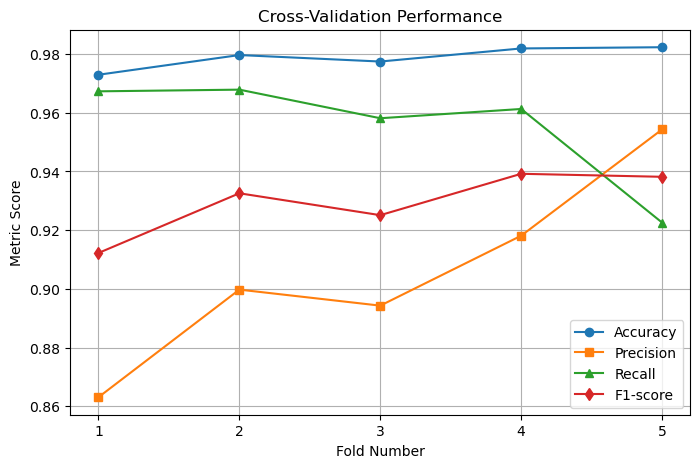

In [21]:
if fold_accuracies:
    avg_acc = np.mean(fold_accuracies)
    avg_prec = np.mean(fold_precisions)
    avg_rec = np.mean(fold_recalls)
    avg_f1 = np.mean(fold_f1s)

    print(f"Average Accuracay: {avg_acc:.4f}")
    print(f"Average Precision: {avg_prec:.4f}")
    print(f"Average Recall: {avg_rec:.4f}")
    print(f"Average F1-score: {avg_f1:.4f}")

    #Plot performance across folds
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', label='Accuracy')
    plt.plot(range(1, len(fold_precisions) + 1), fold_precisions, marker='s', label='Precision')
    plt.plot(range(1, len(fold_recalls) + 1), fold_recalls, marker='^', label='Recall')
    plt.plot(range(1, len(fold_f1s) + 1), fold_f1s, marker='d', label='F1-score')

    plt.xticks(range(1, len(fold_accuracies) + 1))
    plt.xlabel('Fold Number')
    plt.ylabel('Metric Score')
    plt.title('Cross-Validation Performance')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No valid folds with both classes. Check dataset balance.")
